# Sentiment Analysis

In [1]:
import pandas as pd
import re
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import json

from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from pycorenlp import StanfordCoreNLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Helper Function

In [162]:
def print_random(df, category_sentiment, column):
    data = df[df.category_sentiment == category_sentiment].sample(1)
    print("Sentiment Score :", data[column].to_list()[0])
    print("Link Article :", data.link.to_list()[0])
    print(data.content.to_list()[0])

In [3]:
def category_sentiment(compound, threshold_neg=-0.05, threshold_pos=0.05):
    if compound is None : return  None
    if compound < threshold_neg : return "Negative"
    if compound > threshold_pos : return "Positive"
    return "Netral"

In [4]:
def clean_text(text):
    text = unicodedata.normalize("NFKD", text)
    text = re.sub("\xad", "", text)
    
    # hapus titik dibeberapa kata tertentu
    text = re.sub(" Tbk\.", " Tbk ", text)
    text = re.sub(" Tbk", " Tbk ", text)
    text = re.sub(" Rp\.", " ", text)
    text = re.sub(" Rp", " ", text)
    text = re.sub(" PT\.", " PT ", text)
    text = re.sub(" Pt\.", " PT ", text)
    text = re.sub(" dr\.", " ", text)
    text = re.sub(" Dr\.", " ", text)
    text = re.sub(" DR\.", " ", text)
    text = re.sub(" N\.A\.", " ", text)
    text = re.sub(" H\.M\.", " HM", text)    
    text = re.sub(" jl\. ", " jalan ", text)
    text = re.sub(" Jl\. ", " jalan ", text)
    text = re.sub(" Jln\. ", " jalan ", text)
    text = re.sub(" jln\. ", " jalan ", text)    

    # stop words
    text = re.sub("Berikut rincian kurs jual-beli.*$", "", text)
    text = re.sub("(Simak berita lainnya seputar topik.+)$", "", text)
    text = re.sub("--.*--", " ", text) # hapus semua kalimat yang ada di tengah -- dan --
    
    # others pattern
    text = re.sub(r"\. *[0-9]+\. ", ". ", text) # hapus angka yang menunjukkan list seperti 1. 2. yang diawali dengan titik
    text = re.sub(r": *[0-9]+\. ", ". ", text) # hapus angka yang menunjukkan list seperti 1. 2. yang diawali dengan ":"
    text = re.sub("(?<=\d)(?=[a-zA-Z])", " ", text) # memisahkan angka yang berdempetan dengan huruf
    text = re.sub("(?<=[a-zA-Z])(?=\d)", " ", text) # memisahkan huruf yang berdempetan dengan angka
    text = re.sub(" ([a-zA-Z]{1,2})\. ", " ", text) # hapus dua huruf yang diikuti titik karena biasa hanya singkatan nama
    
    # hapus url
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "link-website", text)
    
    text = re.sub("\*", "", text) # hapus bintang
    text = re.sub(r"(?<=\d)[,.](?=\d)", "", text) # hapus titik atau koma ditengah angka
    text = re.sub(":", ": ", text) # menambahkan spasi setelah :
    text = re.sub(r"\.(?=\S)", ". ", text) # ada spasi setelah titik
    text = re.sub(r"\?(?=\S)", "? ", text) # ada spasi setelah tanda tanya
    text = re.sub(r"\)(?=\S)", ") ", text) # ada spasi setelah tutup kurung
    text = re.sub(r"\((?=\S)", " (", text) # ada spasi sebelum tutup kurung

    text = re.sub("\. +\.", ".", text) # hapus spasi diantara dua titik
    text = re.sub(" +\? +", "? ", text) # hapus spasi sebelum tanda tanya
    text = re.sub(" +,", ", ", text) # hapus spasi sebelum koma
    text = re.sub(" +\. ", ". ", text) # hapus spasi sebelum titik
    text = re.sub("\.,", ", ", text) # hapus .,
    
    text = re.sub(" {2,}", " ", text) # hapus spasi yang berulang
    text = re.sub("\.{2,}", ".", text) # hapus titik yang berulang
    text = re.sub("\?{2,}", ".", text) # hapus tanda tanya yang berulang
    
    text = re.sub(r'\. *\([^)]*\)[\. ]', ". ", text) # hapus kurung di awal kalimat
    text = re.sub(r'\. *\([^)]*\)$', ".", text) # hapus kurung di akhir artikel
    
    text = re.sub(" Bisnis\.com", " bisniscom", text)
    text = re.sub(" Bisnis\. com", " bisniscom", text)
    text = re.sub(" bisnis\. com", " bisniscom", text)
    text = re.sub(" bisnis\.com", " bisniscom", text)
    
    return text.strip()

In [5]:
def clean_text(text):
    stop_words = set(stopwords.words('english'))

    try:
        text = text.lower()
        text = re.sub(r'\([^)]*\)', "", text)
        text = re.sub('\d+', "", text)
        text = re.sub(r'[^\w\s]', '', text)
        text = word_tokenize(text)
        text = [word for word in text if word not in stop_words]
        text = ' '.join(text)
        text = re.sub(r' \w{1,2} ', " ", text)
        text = re.sub(" {2,}", " ", text) # hapus spasi yang berulang
        return text.strip()
    
    except Exception as e:
        raise e

## Read Data

In [6]:
with open("data/translate.txt", "r", encoding='utf-8') as f:
    data_translate = json.load(f)

data_translate = pd.DataFrame(data_translate)
data = pd.read_json("data/table_articles.json")

data = (data.set_index("link")
        .join(data_translate.set_index("link"))
        .reset_index())

data['content_clean'] = data.content.apply(clean_text)
data

,link,id,title,content,category,published_at,website,related_to_saham,translate_text,content_clean
0,https://finance.detik.com/bursa-dan-valas/d-12...,1,"IHSG Hanya Naik 1,976 Poin","Pada penutupan perdagangan hari ini, Kamis (1/...",bursa dan valas,2004-04-01 16:22:00,detik finance,"[{'code': 'BBCA', 'company_name': 'PT Bank Cen...","At the close of trading today, Thursday (1/4/2...",pada penutupan perdagangan hari ini kamis inde...
1,https://finance.detik.com/bursa-dan-valas/d-12...,2,"Pelaku Pasar Optimis Pemilu Lancar, IHSG Naik ...",Indeks harga saham gabungan pada penutupan Jum...,bursa dan valas,2004-04-02 16:36:09,detik finance,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...",The Composite Stock Price Index at the close o...,indeks harga saham gabungan pada penutupan jum...
2,https://finance.detik.com/moneter/d-126488/rup...,3,Rupiah Alami Penguatan Terbatas,Pelaksanaan Pemilu yang berjalan lancar dan am...,moneter,2004-04-06 09:27:43,detik finance,"[{'code': 'BBNI', 'company_name': 'PT Bank Neg...",Implementation of elections that run smoothly ...,pelaksanaan pemilu yang berjalan lancar dan am...
3,https://finance.detik.com/bursa-dan-valas/d-12...,4,"IHSG Melejit 13,710 Poin","Pada penutupan sesi pertama, Selasa (6/4/2004)...",bursa dan valas,2004-04-06 12:18:40,detik finance,"[{'code': 'AALI', 'company_name': 'PT Astra Ag...",At the closing of the first session on Tuesday...,pada penutupan sesi pertama selasa indeks harg...
4,https://finance.detik.com/bursa-dan-valas/d-12...,5,"IHSG Melonjak 20,896 Poin",Indeks Harga Saham Gabungan (IHSG) pada penutu...,bursa dan valas,2004-04-06 16:23:18,detik finance,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...",The Composite Stock Price Index (CSPI) at the ...,indeks harga saham gabungan pada penutupan per...
...,...,...,...,...,...,...,...,...,...,...
33575,https://market.bisnis.com/read/20211231/192/14...,33576,"ADRO Royal Tebar Dividen Rp5 Triliun, Ini Daft...",Sejumlah emiten royal membagikan dividen kepad...,Korporasi,2021-12-31 15:49:00,bisnis.com,"[{'code': 'ADRO', 'company_name': 'PT Adaro En...",A number of Royal issuers distributed dividend...,sejumlah emiten royal membagikan dividen kepad...
33576,https://finansial.bisnis.com/read/20211231/90/...,33577,"Berdayakan UMKM dan Kaum Perempuan, BRI Bina K...",PT Bank Rakyat Indonesia (Persero) Tbk. mengan...,Perbankan,2021-12-31 17:46:00,bisnis.com,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...",PT Bank Rakyat Indonesia (Persero) Tbk raised ...,pt bank rakyat indonesia tbk mengangkat potens...
33577,https://finance.detik.com/bursa-dan-valas/d-58...,33578,Said Didu 'Warning' Pemerintah yang Alihkan Sa...,Pemerhati Ekonomi Politik Indonesia sekaligus ...,bursa dan valas,2021-12-31 18:45:50,detik finance,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...",Indonesian political economy observer as well ...,pemerhati ekonomi politik indonesia sekaligus ...
33578,https://finance.detik.com/moneter/d-5879238/al...,33579,"Alihkan Dana Rp 30 Miliar, Wanita Ini Terancam...",Seorang nasabah Bank Rakyat Indonesia (BRI) In...,moneter,2021-12-31 20:56:41,detik finance,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...",A customer of Bank Rakyat Indonesia (BRI) Inda...,seorang nasabah bank rakyat indonesia indah ha...


In [7]:
def clean_text2(text):
    if text is None:
        return None
    sentences = nltk.tokenize.sent_tokenize(text)
    return '. '.join([clean_text(sentence) for sentence in sentences])

data['translate_text_clean'] = data.translate_text.apply(clean_text2)

## VADER

In [8]:
sid = SentimentIntensityAnalyzer()

def veder_sentiment(row, column):
    """Callback for dataframe to do sentiment analysis
    with VADER. Dataframe must contain translate_text column
    """
    text = row[column]
    if text is not None:     
        per_sentence = []
        sentences = nltk.sent_tokenize(text)
        compound = neg = pos = neu = 0
        sentence_length = len(sentences)
        for i, sentence in zip(range(1, sentence_length + 1), sentences):
            sentiment = sid.polarity_scores(sentence.replace('"', ""))    
            compound += sentiment['compound']
            neg += sentiment['neg']
            pos += sentiment['pos']
            neu += sentiment['neu']
            per_sentence.append({
                "sentence_ke" : i,
                "sentence" : sentence,
                "sentiment" : sentiment
            })
        
        row['mean_compound'] = compound / sentence_length
        row['mean_pos'] = pos / sentence_length
        row['mean_neg'] = neg / sentence_length
        row['mean_neu'] = neu / sentence_length
        row['per_sentence'] = per_sentence
        
    return row

In [9]:
data_veder = data.apply(lambda row : veder_sentiment(row, 'translate_text'), axis=1)
data_veder

,category,content,content_clean,id,link,mean_compound,mean_neg,mean_neu,mean_pos,per_sentence,published_at,related_to_saham,title,translate_text,translate_text_clean,website
0,bursa dan valas,"Pada penutupan perdagangan hari ini, Kamis (1/...",pada penutupan perdagangan hari ini kamis inde...,1,https://finance.detik.com/bursa-dan-valas/d-12...,0.423440,0.000000,0.871700,0.128300,"[{'sentence_ke': 1, 'sentence': 'At the close ...",2004-04-01 16:22:00,"[{'code': 'BBCA', 'company_name': 'PT Bank Cen...","IHSG Hanya Naik 1,976 Poin","At the close of trading today, Thursday (1/4/2...",close trading today thursday composite stock p...,detik finance
1,bursa dan valas,Indeks harga saham gabungan pada penutupan Jum...,indeks harga saham gabungan pada penutupan jum...,2,https://finance.detik.com/bursa-dan-valas/d-12...,0.323844,0.008556,0.826000,0.165444,"[{'sentence_ke': 1, 'sentence': 'The Composite...",2004-04-02 16:36:09,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...","Pelaku Pasar Optimis Pemilu Lancar, IHSG Naik ...",The Composite Stock Price Index at the close o...,composite stock price index close friday weeke...,detik finance
2,moneter,Pelaksanaan Pemilu yang berjalan lancar dan am...,pelaksanaan pemilu yang berjalan lancar dan am...,3,https://finance.detik.com/moneter/d-126488/rup...,0.400344,0.053222,0.753444,0.193333,"[{'sentence_ke': 1, 'sentence': 'Implementatio...",2004-04-06 09:27:43,"[{'code': 'BBNI', 'company_name': 'PT Bank Neg...",Rupiah Alami Penguatan Terbatas,Implementation of elections that run smoothly ...,implementation elections run smoothly safely p...,detik finance
3,bursa dan valas,"Pada penutupan sesi pertama, Selasa (6/4/2004)...",pada penutupan sesi pertama selasa indeks harg...,4,https://finance.detik.com/bursa-dan-valas/d-12...,0.460500,0.008727,0.837545,0.153727,"[{'sentence_ke': 1, 'sentence': 'At the closin...",2004-04-06 12:18:40,"[{'code': 'AALI', 'company_name': 'PT Astra Ag...","IHSG Melejit 13,710 Poin",At the closing of the first session on Tuesday...,closing first session tuesday composite stock ...,detik finance
4,bursa dan valas,Indeks Harga Saham Gabungan (IHSG) pada penutu...,indeks harga saham gabungan pada penutupan per...,5,https://finance.detik.com/bursa-dan-valas/d-12...,0.460990,0.000000,0.834600,0.165400,"[{'sentence_ke': 1, 'sentence': 'The Composite...",2004-04-06 16:23:18,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...","IHSG Melonjak 20,896 Poin",The Composite Stock Price Index (CSPI) at the ...,composite stock price index close trading tues...,detik finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33575,Korporasi,Sejumlah emiten royal membagikan dividen kepad...,sejumlah emiten royal membagikan dividen kepad...,33576,https://market.bisnis.com/read/20211231/192/14...,0.262665,0.003882,0.889265,0.106853,"[{'sentence_ke': 1, 'sentence': 'A number of R...",2021-12-31 15:49:00,"[{'code': 'ADRO', 'company_name': 'PT Adaro En...","ADRO Royal Tebar Dividen Rp5 Triliun, Ini Daft...",A number of Royal issuers distributed dividend...,number royal issuers distributed dividends sha...,bisnis.com
33576,Perbankan,PT Bank Rakyat Indonesia (Persero) Tbk. mengan...,pt bank rakyat indonesia tbk mengangkat potens...,33577,https://finansial.bisnis.com/read/20211231/90/...,0.169281,0.002500,0.933654,0.063846,"[{'sentence_ke': 1, 'sentence': 'PT Bank Rakya...",2021-12-31 17:46:00,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...","Berdayakan UMKM dan Kaum Perempuan, BRI Bina K...",PT Bank Rakyat Indonesia (Persero) Tbk raised ...,pt bank rakyat indonesia tbk raised potential ...,bisnis.com
33577,bursa dan valas,Pemerhati Ekonomi Politik Indonesia sekaligus ...,pemerhati ekonomi politik indonesia sekaligus ...,33578,https://finance.detik.com/bursa-dan-valas/d-58...,0.142358,0.050167,0.842625,0.107167,"[{'sentence_ke': 1, 'sentence': 'Indonesian po...",2021-12-31 18:45:50,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...",Said Didu 'Warning' Pemerintah yang Alihkan 

In [10]:
data_veder2 = data.apply(lambda row : veder_sentiment(row, 'translate_text_clean'), axis=1)

## TextBlob

In [11]:
def textblob_sentiment(row, column):
    """Callback for dataframe to do sentiment analysis
    with TextBlob. Dataframe must contain translate_text column
    """
    
    text = row[column]
    if text is not None:
        per_sentence = []
        sentences = nltk.sent_tokenize(text)
        sentiment = 0
        sentence_length = len(sentences)
        sentence_has_sentiment = 0
        for i, sentence in zip(range(1, sentence_length + 1), sentences):
            sentiment_value = TextBlob(sentence.replace('"', "")).sentiment.polarity
            per_sentence.append({
                "sentence_ke" : i,
                "sentence" : sentence,
                "sentiment" : sentiment_value
            })
            
            if sentiment_value != 0:
                sentiment += sentiment_value
                sentence_has_sentiment += 1
        
        row['sentiment'] = sentiment / sentence_has_sentiment if sentence_has_sentiment != 0 else 0
        row['per_sentence'] = per_sentence
        
    return row

In [12]:
data_textblob = data.apply(lambda row : textblob_sentiment(row, 'translate_text'), axis=1)
data_textblob

,category,content,content_clean,id,link,per_sentence,published_at,related_to_saham,sentiment,title,translate_text,translate_text_clean,website
0,bursa dan valas,"Pada penutupan perdagangan hari ini, Kamis (1/...",pada penutupan perdagangan hari ini kamis inde...,1,https://finance.detik.com/bursa-dan-valas/d-12...,"[{'sentence_ke': 1, 'sentence': 'At the close ...",2004-04-01 16:22:00,"[{'code': 'BBCA', 'company_name': 'PT Bank Cen...",0.238284,"IHSG Hanya Naik 1,976 Poin","At the close of trading today, Thursday (1/4/2...",close trading today thursday composite stock p...,detik finance
1,bursa dan valas,Indeks harga saham gabungan pada penutupan Jum...,indeks harga saham gabungan pada penutupan jum...,2,https://finance.detik.com/bursa-dan-valas/d-12...,"[{'sentence_ke': 1, 'sentence': 'The Composite...",2004-04-02 16:36:09,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...",0.291383,"Pelaku Pasar Optimis Pemilu Lancar, IHSG Naik ...",The Composite Stock Price Index at the close o...,composite stock price index close friday weeke...,detik finance
2,moneter,Pelaksanaan Pemilu yang berjalan lancar dan am...,pelaksanaan pemilu yang berjalan lancar dan am...,3,https://finance.detik.com/moneter/d-126488/rup...,"[{'sentence_ke': 1, 'sentence': 'Implementatio...",2004-04-06 09:27:43,"[{'code': 'BBNI', 'company_name': 'PT Bank Neg...",0.040778,Rupiah Alami Penguatan Terbatas,Implementation of elections that run smoothly ...,implementation elections run smoothly safely p...,detik finance
3,bursa dan valas,"Pada penutupan sesi pertama, Selasa (6/4/2004)...",pada penutupan sesi pertama selasa indeks harg...,4,https://finance.detik.com/bursa-dan-valas/d-12...,"[{'sentence_ke': 1, 'sentence': 'At the closin...",2004-04-06 12:18:40,"[{'code': 'AALI', 'company_name': 'PT Astra Ag...",0.299067,"IHSG Melejit 13,710 Poin",At the closing of the first session on Tuesday...,closing first session tuesday composite stock ...,detik finance
4,bursa dan valas,Indeks Harga Saham Gabungan (IHSG) pada penutu...,indeks harga saham gabungan pada penutupan per...,5,https://finance.detik.com/bursa-dan-valas/d-12...,"[{'sentence_ke': 1, 'sentence': 'The Composite...",2004-04-06 16:23:18,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...",0.309705,"IHSG Melonjak 20,896 Poin",The Composite Stock Price Index (CSPI) at the ...,composite stock price index close trading tues...,detik finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33575,Korporasi,Sejumlah emiten royal membagikan dividen kepad...,sejumlah emiten royal membagikan dividen kepad...,33576,https://market.bisnis.com/read/20211231/192/14...,"[{'sentence_ke': 1, 'sentence': 'A number of R...",2021-12-31 15:49:00,"[{'code': 'ADRO', 'company_name': 'PT Adaro En...",0.212727,"ADRO Royal Tebar Dividen Rp5 Triliun, Ini Daft...",A number of Royal issuers distributed dividend...,number royal issuers distributed dividends sha...,bisnis.com
33576,Perbankan,PT Bank Rakyat Indonesia (Persero) Tbk. mengan...,pt bank rakyat indonesia tbk mengangkat potens...,33577,https://finansial.bisnis.com/read/20211231/90/...,"[{'sentence_ke': 1, 'sentence': 'PT Bank Rakya...",2021-12-31 17:46:00,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...",0.230830,"Berdayakan UMKM dan Kaum Perempuan, BRI Bina K...",PT Bank Rakyat Indonesia (Persero) Tbk raised ...,pt bank rakyat indonesia tbk raised potential ...,bisnis.com
33577,bursa dan valas,Pemerhati Ekonomi Politik Indonesia sekaligus ...,pemerhati ekonomi politik indonesia sekaligus ...,33578,https://finance.detik.com/bursa-dan-valas/d-58...,"[{'sentence_ke': 1, 'sentence': 'Indonesian po...",2021-12-31 18:45:50,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...",0.009762,Said Didu 'Warning' Pemerintah yang Alihkan Sa...,Indonesian political economy observer as well ...,indonesian political economy observer well for...,detik finance
33578,moneter,Seorang nasabah Bank Rakyat Indonesia (BRI) In...,seorang nasabah bank rakyat indonesia indah ha...,33579,https://finance.det

In [13]:
data_textblob2 = data.apply(lambda row : textblob_sentiment(row, 'translate_text_clean'), axis=1)

## SentiWordNet

In [14]:
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def get_sentiment_swn(sentence):
    token = nltk.word_tokenize(sentence)
    after_tagging = nltk.pos_tag(token)
    after_tagging

    sentiment = 0.0
    tokens_count = 0

    lemmatizer = WordNetLemmatizer()

    for word, tag in after_tagging:
        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV): continue

        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        if not lemma: continue

        synsets = wn.synsets(lemma, pos=wn_tag)
        if not synsets: continue

        # Take the first sense, the most common
        synset = synsets[0]    
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
    
    return sentiment / tokens_count if tokens_count != 0 else 0

def swn_sentiment(row, column):
    """Callback for dataframe to do sentiment analysis
    with SentiWordNet. Dataframe must contain translate_text column
    """
    
    text = row[column]
    if text is not None:
        per_sentence = []
        sentences = nltk.sent_tokenize(text)
        sentiment = 0
        sentence_length = len(sentences)
        sentence_has_sentiment = 0
        for i, sentence in zip(range(1, sentence_length + 1), sentences):
            sentiment_value = get_sentiment_swn(sentence.replace('"', ""))
            per_sentence.append({
                "sentence_ke" : i,
                "sentence" : sentence,
                "sentiment" : sentiment_value
            })
            if sentiment_value != 0:
                sentiment += sentiment_value
                sentence_has_sentiment += 1
        
        row['sentiment'] = sentiment / sentence_has_sentiment if sentence_has_sentiment != 0 else 0
        row['per_sentence'] = per_sentence
        
    return row

In [15]:
data_swn = data.apply(lambda row : swn_sentiment(row, 'translate_text'), axis=1)
data_swn

,category,content,content_clean,id,link,per_sentence,published_at,related_to_saham,sentiment,title,translate_text,translate_text_clean,website
0,bursa dan valas,"Pada penutupan perdagangan hari ini, Kamis (1/...",pada penutupan perdagangan hari ini kamis inde...,1,https://finance.detik.com/bursa-dan-valas/d-12...,"[{'sentence_ke': 1, 'sentence': 'At the close ...",2004-04-01 16:22:00,"[{'code': 'BBCA', 'company_name': 'PT Bank Cen...",-0.024798,"IHSG Hanya Naik 1,976 Poin","At the close of trading today, Thursday (1/4/2...",close trading today thursday composite stock p...,detik finance
1,bursa dan valas,Indeks harga saham gabungan pada penutupan Jum...,indeks harga saham gabungan pada penutupan jum...,2,https://finance.detik.com/bursa-dan-valas/d-12...,"[{'sentence_ke': 1, 'sentence': 'The Composite...",2004-04-02 16:36:09,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...",-0.023242,"Pelaku Pasar Optimis Pemilu Lancar, IHSG Naik ...",The Composite Stock Price Index at the close o...,composite stock price index close friday weeke...,detik finance
2,moneter,Pelaksanaan Pemilu yang berjalan lancar dan am...,pelaksanaan pemilu yang berjalan lancar dan am...,3,https://finance.detik.com/moneter/d-126488/rup...,"[{'sentence_ke': 1, 'sentence': 'Implementatio...",2004-04-06 09:27:43,"[{'code': 'BBNI', 'company_name': 'PT Bank Neg...",0.034848,Rupiah Alami Penguatan Terbatas,Implementation of elections that run smoothly ...,implementation elections run smoothly safely p...,detik finance
3,bursa dan valas,"Pada penutupan sesi pertama, Selasa (6/4/2004)...",pada penutupan sesi pertama selasa indeks harg...,4,https://finance.detik.com/bursa-dan-valas/d-12...,"[{'sentence_ke': 1, 'sentence': 'At the closin...",2004-04-06 12:18:40,"[{'code': 'AALI', 'company_name': 'PT Astra Ag...",-0.039708,"IHSG Melejit 13,710 Poin",At the closing of the first session on Tuesday...,closing first session tuesday composite stock ...,detik finance
4,bursa dan valas,Indeks Harga Saham Gabungan (IHSG) pada penutu...,indeks harga saham gabungan pada penutupan per...,5,https://finance.detik.com/bursa-dan-valas/d-12...,"[{'sentence_ke': 1, 'sentence': 'The Composite...",2004-04-06 16:23:18,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...",0.000691,"IHSG Melonjak 20,896 Poin",The Composite Stock Price Index (CSPI) at the ...,composite stock price index close trading tues...,detik finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33575,Korporasi,Sejumlah emiten royal membagikan dividen kepad...,sejumlah emiten royal membagikan dividen kepad...,33576,https://market.bisnis.com/read/20211231/192/14...,"[{'sentence_ke': 1, 'sentence': 'A number of R...",2021-12-31 15:49:00,"[{'code': 'ADRO', 'company_name': 'PT Adaro En...",0.001931,"ADRO Royal Tebar Dividen Rp5 Triliun, Ini Daft...",A number of Royal issuers distributed dividend...,number royal issuers distributed dividends sha...,bisnis.com
33576,Perbankan,PT Bank Rakyat Indonesia (Persero) Tbk. mengan...,pt bank rakyat indonesia tbk mengangkat potens...,33577,https://finansial.bisnis.com/read/20211231/90/...,"[{'sentence_ke': 1, 'sentence': 'PT Bank Rakya...",2021-12-31 17:46:00,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...",0.006539,"Berdayakan UMKM dan Kaum Perempuan, BRI Bina K...",PT Bank Rakyat Indonesia (Persero) Tbk raised ...,pt bank rakyat indonesia tbk raised potential ...,bisnis.com
33577,bursa dan valas,Pemerhati Ekonomi Politik Indonesia sekaligus ...,pemerhati ekonomi politik indonesia sekaligus ...,33578,https://finance.detik.com/bursa-dan-valas/d-58...,"[{'sentence_ke': 1, 'sentence': 'Indonesian po...",2021-12-31 18:45:50,"[{'code': 'BBRI', 'company_name': 'PT Bank Rak...",0.027143,Said Didu 'Warning' Pemerintah yang Alihkan Sa...,Indonesian political economy observer as well ...,indonesian political economy observer well for...,detik finance
33578,moneter,Seorang nasabah Bank Rakyat Indonesia (BRI) In...,seorang nasabah bank rakyat indonesia indah ha...,33579,https://finance.

In [16]:
data_swn2 = data.apply(lambda row : swn_sentiment(row, 'translate_text_clean'), axis=1)

## CoreNLP

In [17]:
nlp = StanfordCoreNLP('http://localhost:5000')

def get_sentiment_corenlp(text):    
    try:
        result = nlp.annotate(text, properties={
            'annotators': 'sentiment',
            'outputFormat': 'json',
            'timeout': 10000000})
    
        return result['sentences'][0]['sentiment']
    except Exception as e:
        raise e

def corenlp_sentiment(row):
    """Callback for dataframe to do sentiment analysis
    with CoreNLP. Dataframe must contain translate_text column
    """
    
    text = row['translate_text']
    if text is not None:
        text = clean_text(text)
        per_sentence = []
        sentences = nltk.sent_tokenize(text)
        sentence_length = len(sentences)
        for i, sentence in zip(range(1, sentence_length + 1), sentences):            
            try:
                sentiment_value = get_sentiment_corenlp(sentence.replace('"', ""))
            except:
                sentiment_value = None
            finally:
                per_sentence.append({
                    "sentence_ke" : i,
                    "sentence" : sentence,
                    "sentiment" : sentiment_value
                })
        row['per_sentence'] = per_sentence
    return row

In [18]:
# data_corenlp = data.apply(corenlp_sentiment, axis=1)
# data_corenlp2 = data.apply(corenlp_sentiment, axis=1)

## Analisis Hasil

Disini akan dibandingkan 3 metode yaitu `VADER`, `TextBlob` dan `SentiWordNet`. Akan diamati juga efek dari melakukan preprocessing data case folding, remove panctuation, and remove number. Hal ini coba diamati karena berdasarkan dokumentasi dari model tersebut, disebutkan bahwa ketiga model tersebut dapat membedakan antara kalimat `I love you` dan `I LOVE YOU!!`, yang mana kalimat kedua akan memiliki sentiment yang lebih positif daripada kalimat pertama dikarenakan penggunaan huruf kapital dan tanda seru.

Selain itu akan dilihat juga seberapa banyak artikel yang tidak konsisten dimasukkan ke kategori tertentu. Misalnya model `VADER` mengkategorikan artikel 1 sebagai artikel positif tetapi model `TextBlob` mengkategotikannya sebagai netral. Dari yang tidak konsisten tersebut akan dilihat model mana yang lebih benar, dan yang relatif lebih banyak benarnya akan dipilih menjadi model sentiment analisis yang digunakan

### Define Function

In [149]:
def category_sentiment(compound, threshold_neg=-0.05, threshold_pos=0.05):
    if compound is None : return  None
    if compound < threshold_neg : return "Negative"
    if compound > threshold_pos : return "Positive"
    return "Netral"

def get_category_sentiment(data, column, thresh_b = -0.05, thresh_a = 0.05):
    data = data.copy()
    data['date'] = data.published_at.dt.strftime("%Y-%m-%d")
    data['year'] = data.published_at.dt.strftime("%Y")
    data['category_sentiment'] = data[column].apply(lambda x : category_sentiment(x, thresh_b, thresh_a))
    return data

def plot_per_year(data):
    tmp = (data.groupby('year')['category_sentiment']
            .value_counts()
            .to_frame()
            .rename(columns={"category_sentiment" : "jumlah"})
            .reset_index()
            .set_index('year')
            .join(data.groupby('year')['category_sentiment']
                .count()
                .to_frame()
                .rename(columns={"category_sentiment" : "jumlah_per_tahun"}))
            .reset_index())

    tmp['persentase'] = tmp['jumlah'] / tmp['jumlah_per_tahun'] * 100
    tmp[tmp.category_sentiment == 'Negative'][['year', 'persentase']].set_index('year').plot.bar(figsize=(20, 7), title="Persentase Negative")
    
def get_plot(data, column):
    data[column].hist(), print(data.category_sentiment.value_counts()), plot_per_year(data)
    
from scipy.stats import spearmanr, pearsonr, wilcoxon, mannwhitneyu

def bandingkan(data_no_pre, data_with_pre, column):
    x = data_no_pre[column]
    y = data_with_pre[column]

    print(spearmanr(x, y, nan_policy="omit"))

    nas = np.logical_or(x.isnull(), y.isnull())
    print(pearsonr(x[~nas], y[~nas]))
    print(mannwhitneyu(x[~nas], y[~nas]))
    print(wilcoxon(x[~nas], y[~nas]))
    print('Jumlah yang naik nilai sentimentnya', (x > y).sum())
    print('Jumlah yang turun nilai sentimentnya', (x < y).sum())
    print('Jumlah yang sama nilai sentimentnya', (x == y).sum())
    
    not_same = data_no_pre.category_sentiment != data_with_pre.category_sentiment
    print('Jumlah yang sentimentnya berubah setelah dipreprocessing' ,not_same.sum())
    
    tmp_ns = data_no_pre[['content']].copy()
    tmp_ns.loc[:, 'no_pre'] = data_no_pre.category_sentiment
    tmp_ns.loc[:, 'with_pre'] = data_with_pre.category_sentiment
    print(tmp_ns[not_same][['no_pre', 'with_pre']].value_counts())

### VADER

#### Tanpa Preprocessing

Positive    28573
Netral       3459
Negative     1548
Name: category_sentiment, dtype: int64


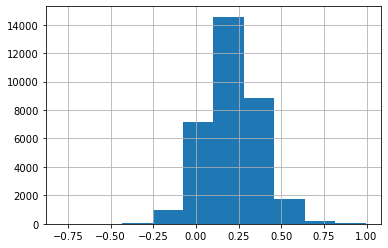

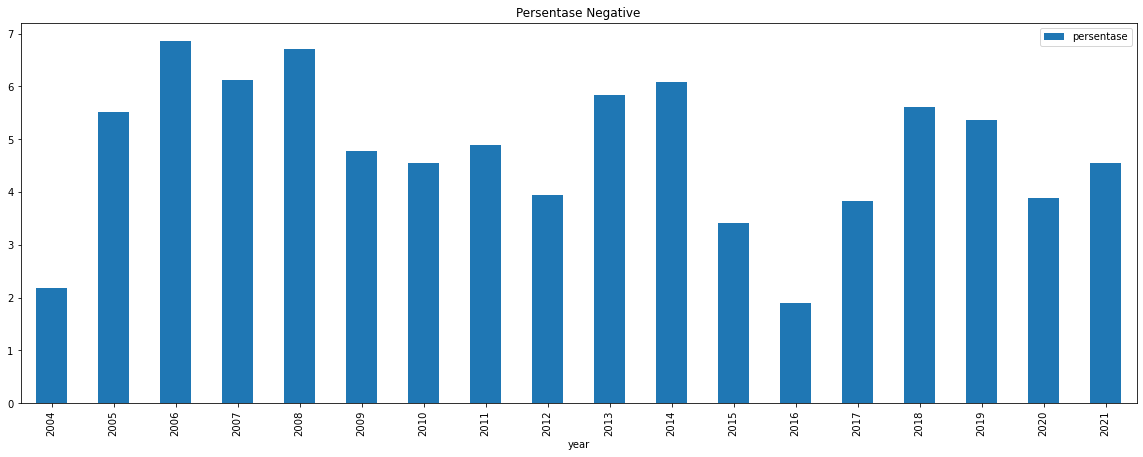

In [754]:
data_veder = get_category_sentiment(data_veder, 'mean_compound')
get_plot(data_veder, 'mean_compound')

In [768]:
def get_random(data):
    data = data.copy().sample(1)
    try:
        print("Sentiment Score", data.mean_compound.values)
    except:
        print("Sentiment Score", data.sentiment.values)
        
    print("Link", data.link.values)
    print(data.content.values)
    
    return  data.link.values[0]

In [792]:
neg = data_textblob[(data_textblob.sentiment > 0.2) & (data_veder.mean_compound < -0.2)]
link = get_random(neg)

Sentiment Score [0.3625]
Link ['https://finance.detik.com/moneter/d-3929537/bank-mandiri-ganti-uang-korban-skimming-rp-260-juta']
['Sejumlah nasabah PT Bank Mandiri Tbk (Bank Mandiri) di Surabaya kehilangan uang secara misterius di rekeningnya. Kehilangan ini diduga pencurian menggunakan modus skimming.Corporate Secretary Bank Mandiri Rohan Hafas menjelaskan, perseroan telah mengganti seluruh kerugian uang nasabah yang hilang. "Seluruh nasabah Bank Mandiri yang jadi korban sudah diganti uangnya Senin malam sudah selesai, 140 nasabah totalnya Rp 260 juta," kata Rohan dalam konferensi pers di Plaza Mandiri, Jakarta, Rabu (21/3/2018).  Rohan menjelaskan untuk mengurangi kejadian pencurian, Mandiri melakukan pemblokiran sementara untuk kartu-kartu ATM yang digunakan di mesin yang terindikasi skimming. Ini dilakukan untuk meminimalisir risiko hilangnya uang nasabah dalam jumlah yang lebih besar."Kita blokir dulu untuk mengamankan uang nasabah. Nanti nasabah pasti bertanya-tanya kan kenapa m

In [793]:
data_veder[data_veder.link == link]

,category,content,content_clean,id,link,mean_compound,mean_neg,mean_neu,mean_pos,per_sentence,published_at,related_to_saham,title,translate_text,translate_text_clean,website,date,year,category_sentiment
17993,moneter,Sejumlah nasabah PT Bank Mandiri Tbk (Bank Man...,sejumlah nasabah bank mandiri tbk surabaya keh...,17994,https://finance.detik.com/moneter/d-3929537/ba...,-0.230654,0.136,0.813692,0.050231,"[{'sentence_ke': 1, 'sentence': 'A number of c...",2018-03-21 21:11:04,"[{'code': 'BMRI', 'company_name': 'PT Bank Man...",Bank Mandiri Ganti Uang Korban Skimming Rp 260...,A number of customers of PT Bank Mandiri Tbk (...,number customers bank mandiri tbk surabaya los...,detik finance,2018-03-21,2018,Negative


#### Dengan Preprocessing

Positive    28868
Netral       3270
Negative     1442
Name: category_sentiment, dtype: int64


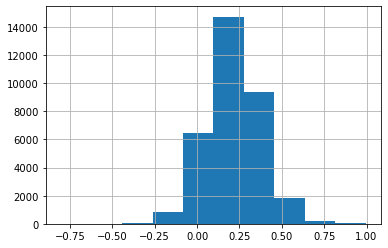

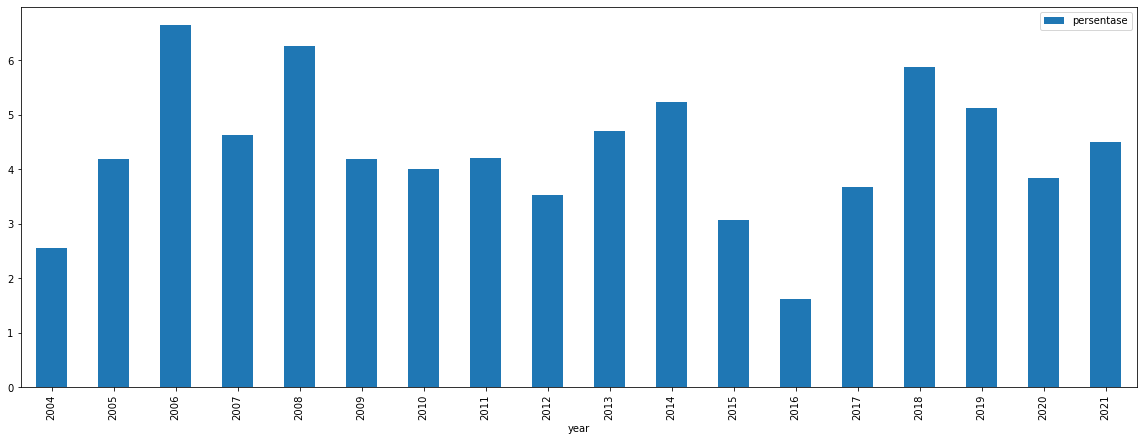

In [145]:
data_veder2 = get_category_sentiment(data_veder2, 'mean_compound')
get_plot(data_veder2, 'mean_compound')

#### Membandingkan Keduanya

In [146]:
bandingkan(data_veder, data_veder2, 'mean_compound')

SpearmanrResult(correlation=0.982764365019005, pvalue=0.0)
(0.9840016943850762, 0.0)
MannwhitneyuResult(statistic=554087788.5, pvalue=5.759608138930519e-05)
WilcoxonResult(statistic=70324426.5, pvalue=5.536904950468098e-187)
Jumlah yang naik nilai sentimentnya 8794
Jumlah yang turun nilai sentimentnya 10477
Jumlah yang sama nilai sentimentnya 14308
Jumlah yang sentimentnya berubah setelah dipreprocessing 1093
no_pre    with_pre
Netral    Positive    529
Positive  Netral      242
Negative  Netral      193
Netral    Negative     95
Negative  Positive     21
Positive  Negative     13
dtype: int64


In [672]:
perbedaan = data_veder.mean_compound - data_veder2.mean_compound
perbedaan[perbedaan != 0].abs().median()

0.014616666666666722

Dari hasil ini terlihat bahwa preprocessing membuat banyak yang awalnya netral menjadi positif, bisa jadi dengan preprocessing akan memiliki efek untuk menghilangkan kata-kata yang tidak berguna. Model VADER ini juga cukup konsisten dimana perpindahan dari negatif ke positif atau sebaliknya hanya terjadi sedikit yaitu hanya ada 34 artikel. Nilai sentimennya juga memiliki korelasi yang sangat tinggi. yang nilainya tidak berubah juga sangat banyak ada 14 ribuan. Tapi sayangnya pas diuji dengan wilcoxon/manwhitney keduanya signifikan berbeda.

### TextBlob

#### Tanpa Preprocessing

Positive    26084
Netral       5789
Negative     1707
Name: category_sentiment, dtype: int64


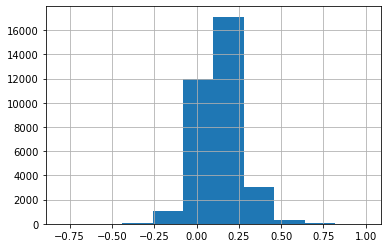

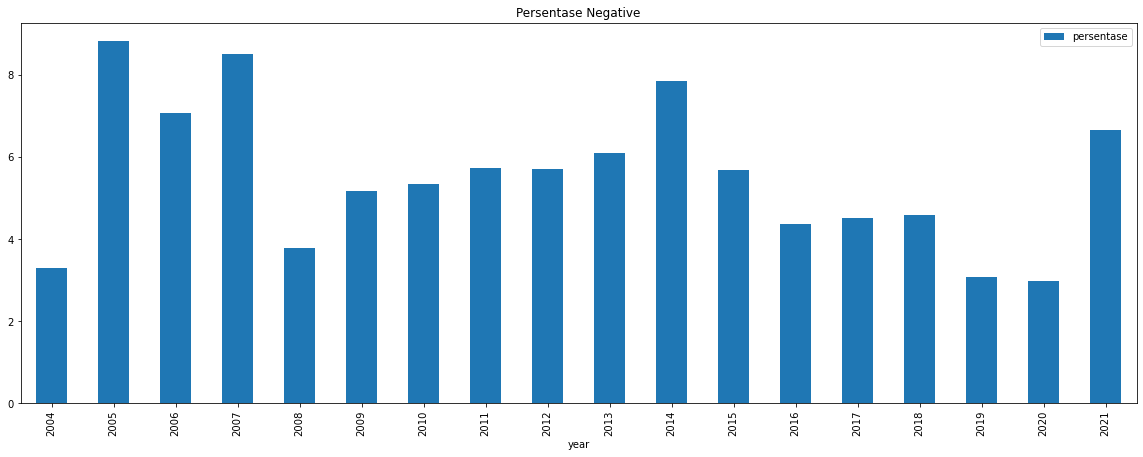

In [753]:
data_textblob = get_category_sentiment(data_textblob, 'sentiment')
get_plot(data_textblob, 'sentiment')

#### Dengan Preprocessing

Positive    26129
Netral       5582
Negative     1869
Name: category_sentiment, dtype: int64


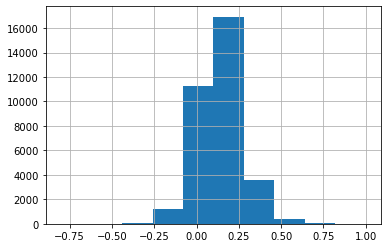

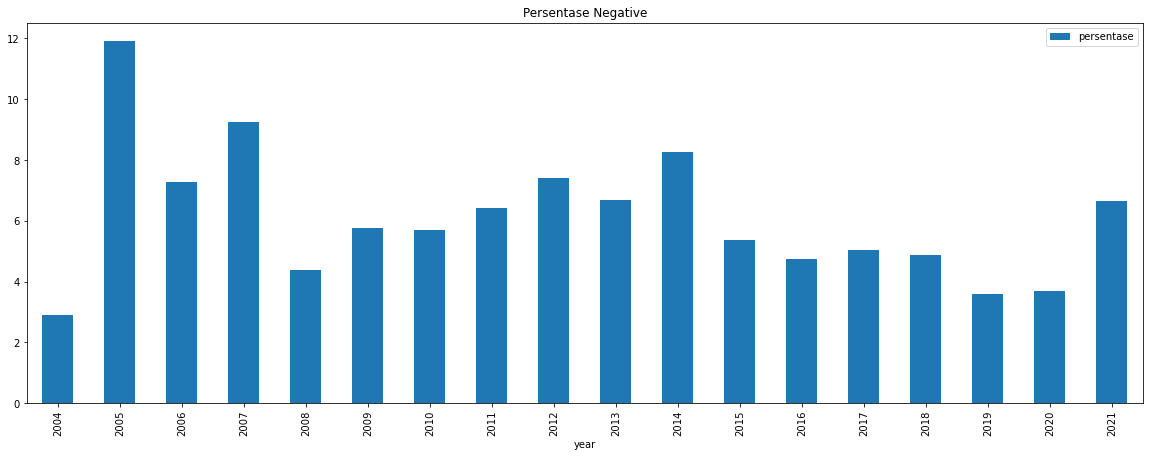

In [151]:
data_textblob2 = get_category_sentiment(data_textblob2, 'sentiment')
get_plot(data_textblob2, 'sentiment')

#### Membandingkan Keduanya

In [152]:
bandingkan(data_textblob, data_textblob2, 'sentiment')

SpearmanrResult(correlation=0.9106786017061974, pvalue=0.0)
(0.9205461706153093, 0.0)
MannwhitneyuResult(statistic=547762950.0, pvalue=9.211403628912887e-11)
WilcoxonResult(statistic=135033032.5, pvalue=1.530501457530387e-198)
Jumlah yang naik nilai sentimentnya 10529
Jumlah yang turun nilai sentimentnya 15691
Jumlah yang sama nilai sentimentnya 7359
Jumlah yang sentimentnya berubah setelah dipreprocessing 2977
no_pre    with_pre
Netral    Positive    1190
Positive  Netral      1095
Netral    Negative     340
Negative  Netral       228
Positive  Negative      87
Negative  Positive      37
dtype: int64


In [676]:
perbedaan = data_textblob.sentiment - data_textblob2.sentiment
perbedaan[perbedaan != 0].abs().median()

0.024412457912457903

Sentimen score antara data yang dipreprocessing dan tidak masih memiliki korelasi yang sangat tinggi. Yang berubah sentimennya cukup banyak hampir 3000 atau sekitar 9%, yang banyak berpindah itu dari netral ke positif atau sebaliknya. Artinya cukup banyak yang berada disekitar ambang batas 0.05 sehingga mudah banget terjadi perubahan.

Akan tetapi jika dibandingkan dengan VADER, textblob ini lebih sensitif dengan tahapan preprocessing. Hal tersebut terlihat dari korelasi kedua variabel yang lebih rendah dari korelasi ketika menggunakan VEDER, terlihat juga perubahan sentimennya jauh lebih banyak, 2 kali lipat lebih dari model vader

### SentiWordNet

#### Tanpa Preprocessing

Netral      28387
Negative     2817
Positive     2376
Name: category_sentiment, dtype: int64


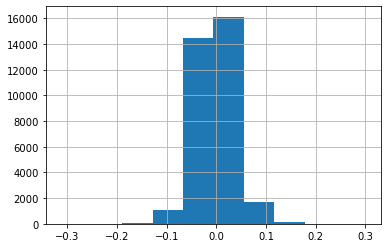

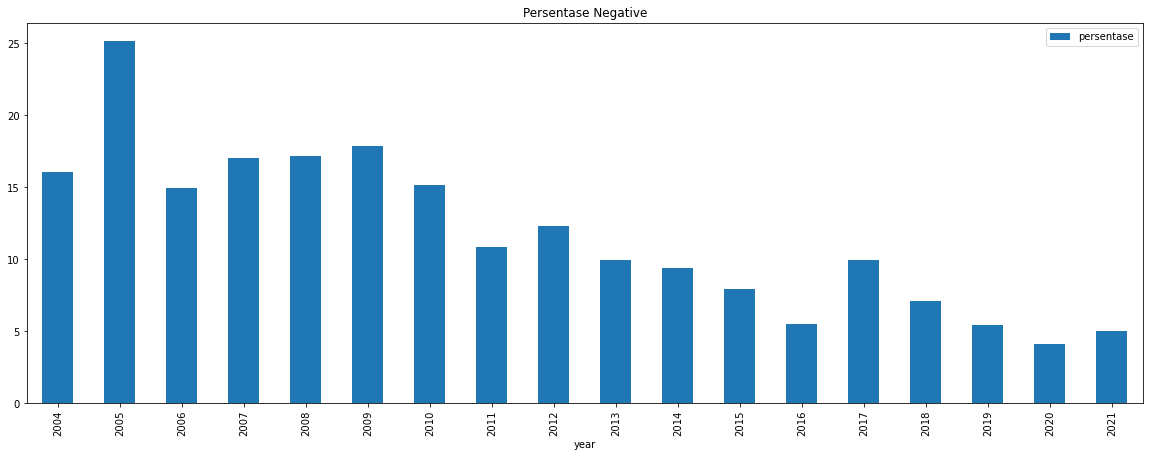

In [168]:
data_swn = get_category_sentiment(data_swn, 'sentiment', -0.05, 0.05)
get_plot(data_swn, 'sentiment')

#### Dengan Preprocessing

Netral      26895
Positive     4902
Negative     1783
Name: category_sentiment, dtype: int64


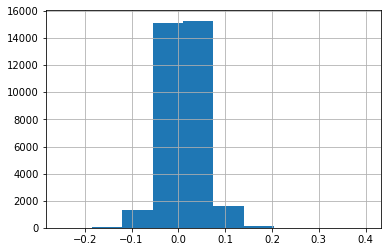

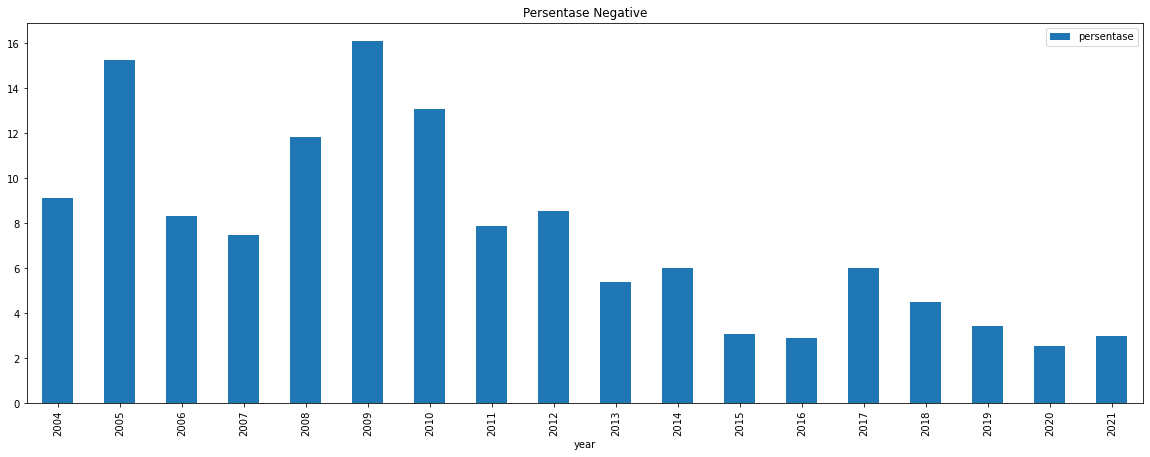

In [170]:
data_swn2 = get_category_sentiment(data_swn2, 'sentiment', -0.05, 0.05)
get_plot(data_swn2, 'sentiment')

#### Membandingkan Keduanya

In [172]:
bandingkan(data_swn, data_swn2, 'sentiment')

SpearmanrResult(correlation=0.8179664770447088, pvalue=0.0)
(0.8117744672427689, 0.0)
MannwhitneyuResult(statistic=444684956.5, pvalue=0.0)
WilcoxonResult(statistic=86691164.0, pvalue=0.0)
Jumlah yang naik nilai sentimentnya 7489
Jumlah yang turun nilai sentimentnya 25808
Jumlah yang sama nilai sentimentnya 282
Jumlah yang sentimentnya berubah setelah dipreprocessing 5092
no_pre    with_pre
Netral    Positive    2734
Negative  Netral      1534
Netral    Negative     536
Positive  Netral       244
Negative  Positive      40
Positive  Negative       4
dtype: int64


Jauh lebih ga konsisten, terlihat dari hasil korelasinya. Sentiment scorenya juga hampir berubah semua, sentiment categorynya juga sangat berubah, ada 5092 artikel yang berubah sentiment categorynya, yang banyak berpindah memang dari netral ke positif

Dilihat dari kestabilan sentimentnya sih lebih milih VADER terus TextBlob dan terakhir baru SentiWordNet

### Bandingkan Hasil Ketiga Metode

In [745]:
tiga = data[['content', 'link']].copy()
tiga.loc[:, 'sentiment_vader'] = data_veder.category_sentiment
tiga.loc[:, 'sentiment_textblob'] = data_textblob.category_sentiment
# tiga.loc[:, 'sentiment_swn'] = data_swn.category_sentiment

column_sentimen = tiga.columns.to_series().str.startswith('sentiment').to_list()
(tiga.iloc[:, column_sentimen]
    .value_counts()
    .to_frame()
    .reset_index()
    .sort_values(['sentiment_vader', 'sentiment_textblob']))

,sentiment_vader,sentiment_textblob,0
3,Negative,Negative,715
7,Negative,Netral,43
2,Negative,Positive,1954
8,Netral,Negative,40
5,Netral,Netral,141
6,Netral,Positive,108
1,Positive,Negative,2711
4,Positive,Netral,291
0,Positive,Positive,27577


In [755]:
tiga = data[['content', 'link']].copy()
tiga.loc[:, 'sentiment_vader'] = data_veder2.category_sentiment
tiga.loc[:, 'sentiment_textblob'] = data_textblob2.category_sentiment
# tiga.loc[:, 'sentiment_swn'] = data_swn.category_sentiment

column_sentimen = tiga.columns.to_series().str.startswith('sentiment').to_list()
(tiga.iloc[:, column_sentimen]
    .value_counts()
    .to_frame()
    .reset_index()
    .sort_values(['sentiment_vader', 'sentiment_textblob']))

,sentiment_vader,sentiment_textblob,0
8,Negative,Negative,290
6,Negative,Netral,391
5,Negative,Positive,761
7,Netral,Negative,344
4,Netral,Netral,874
2,Netral,Positive,2052
3,Positive,Negative,1235
1,Positive,Netral,4317
0,Positive,Positive,23316


## Modeling

Modeling disini hanya bertujuan untuk melihat bagaimana akurasi antara model yang menggunakan VADER dan TextBlob. Selain itu dilihat juga efek dari menggunakan hasil yang preprocessing dan yang tidak menggunakan preprocessing

### Define Class and Function

In [389]:
saham = pd.read_json("data/table_saham.json")
saham

,id,code,company_name
0,1,BBCA,PT Bank Central Asia Tbk
1,2,BBNI,PT Bank Negara Indonesia
2,3,BBRI,PT Bank Rakyat Indonesia
3,4,BMRI,PT Bank Mandiri


In [400]:
def get_article_bank(data, saham_id, column):
    
    article_saham = pd.read_json("data/table_article_saham.json")
    bbri = article_saham[article_saham.saham_id == saham_id]

    bbri_article = data[data.id.isin(bbri.article_id.to_list())]
    bbri_sentiment = (bbri_article
                    .groupby('date')[column]
                    .mean()
                    .to_frame()
                    .reset_index()
                    .rename(columns={column : "sentiment"}))

    bbri_saham = pd.read_csv('data/harga_saham/BBRI.csv')
    bbri_saham = bbri_saham[['Date', 'Close']].rename(columns={"Date" : "date", "Close" : "close"})
    
    bbri_full = pd.merge(bbri_saham, bbri_sentiment, on='date', how='outer').sort_values("date").reset_index(drop=True)
    bbri_full['sentiment'] = bbri_full.sentiment.fillna(0)

    close_null = bbri_full[bbri_full.close.isnull()].index.to_list()
    index_close_null = 0
    index_curr = -1
    sentiment = 0
    count_consecutive_day = 0

    while index_close_null <= len(close_null) - 1:
        index_curr = close_null[index_close_null]
        sentiment = bbri_full.sentiment[index_curr]
        count_consecutive_day = 1
        index_curr += 1
        
        while index_curr in close_null:
            sentiment += bbri_full.sentiment[index_curr]
            count_consecutive_day += 1
            index_curr += 1
            index_close_null += 1
        
        try:
            if bbri_full.sentiment[index_curr] != 0: 
                sentiment += bbri_full.sentiment[index_curr]
                count_consecutive_day += 1
                
            bbri_full.loc[index_curr, "sentiment"] = sentiment / count_consecutive_day
        except:
            pass
        finally:
            index_close_null += 1
            

    return bbri_full[bbri_full.close.notnull()].set_index('date')

In [635]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error, mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

class RegLSTM():
    def __init__(self, data) -> None:
        self.data = data
        self.model = None
        self.history = None

    def split_sequences(self, data, n_steps):
        data = data.to_numpy()
        X = []
        for i in range(len(data)):
            end_ix = i + n_steps
            if end_ix >= len(data):
                break
            
            seq_x= data[i:end_ix, :]
            X.append(seq_x)
            
        return np.array(X)

    def split_train_test(self, X, y, n_test):
        return X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
    
    def plot_history(self):
        # plot history
        plt.plot(self.history.history['loss'], label='train')
        plt.plot(self.history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    
    def run_model(self, X_train, y_train, X_test, y_test, lr=0.001, verbose=1):
        # design network
        _, n_steps, n_features = X_train.shape
        self.model = Sequential([
            # LSTM(units = 64, input_shape=(n_steps, n_features),  activation="tanh", return_sequences = True),
            # LSTM(units = 32, input_shape=(n_steps, n_features),  activation="tanh"),
            LSTM(units = 50, input_shape=(n_steps, n_features),  activation="relu"),
            Dense(1)
        ])
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=lr))

        # fit network
        self.history = self.model.fit(X_train, y_train, epochs=300, batch_size=64,
                            validation_data=(X_test, y_test), verbose=verbose, shuffle=False)
    
    def summary_model(self):
        print("Shape data train : ", self.X_train.shape, self.y_train.shape)
        print("Shape data test : ", self.X_test.shape, self.y_test.shape)
        
        predict_train = self.model.predict(self.X_train).reshape(-1)
        predict_test = self.model.predict(self.X_test).reshape(-1)

        print("RMSE Train", np.sqrt(mean_squared_error(self.y_train, predict_train)))
        print("RMSE Test", np.sqrt(mean_squared_error(self.y_test, predict_test)))
        print("MAE Train", mean_absolute_error(self.y_train, predict_train))
        print("MAE Test", mean_absolute_error(self.y_test, predict_test))
    
    def train_model(self, n_steps, n_test=30, lr=0.001):
        X = self.split_sequences(self.data, n_steps)
        y = self.data.close.to_numpy()[n_steps:]
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_train_test(X, y, n_test=n_test)
        self.run_model(self.X_train, self.y_train, self.X_test, self.y_test, lr=lr)
        
    def summary_train_multiple(self):
        print("Mean RMSE Train", np.mean(self.rmse_train))
        print("Mean RMSE Test", np.mean(self.rmse_test))
        print("Mean MAE Train", np.mean(self.mae_train))
        print("Mean MAE Test", np.mean(self.mae_test))
        
    def train_multiple(self, n_iterate, n_steps, n_test=30, lr=0.001):
        self.rmse_train = []
        self.rmse_test = []
        self.mae_train = []
        self.mae_test = []
        
        X = self.split_sequences(self.data, n_steps)
        y = self.data.close.to_numpy()[n_steps:]
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_train_test(X, y, n_test=n_test)
        
        for _ in range(n_iterate):
            self.run_model(self.X_train, self.y_train, self.X_test, self.y_test, lr=lr, verbose=0)
            
            predict_train = self.model.predict(self.X_train).reshape(-1)
            predict_test = self.model.predict(self.X_test).reshape(-1)
            
            self.rmse_train.append(np.sqrt(mean_squared_error(self.y_train, predict_train)))
            self.rmse_test.append(np.sqrt(mean_squared_error(self.y_test, predict_test)))
            self.mae_train.append(mean_absolute_error(self.y_train, predict_train))
            self.mae_test.append(mean_absolute_error(self.y_test, predict_test))
        
        self.summary_train_multiple()

### VADER

#### No Preprocessing

In [638]:
bbri_no_pre_vader = get_article_bank(data_veder, 3, "mean_compound")

In [639]:
mnp_vader1 = RegLSTM(bbri_no_pre_vader)
mnp_vader1.train_multiple(n_iterate=10, n_steps=5)

Mean RMSE Train 48.97122915227426
Mean RMSE Test 57.95803474416319
Mean MAE Train 30.168880852140138
Mean MAE Test 49.65521240234376


In [640]:
mnp_vader2 = RegLSTM(bbri_no_pre_vader[['close']])
mnp_vader2.train_multiple(n_iterate=10, n_steps=5)

Mean RMSE Train 50.31188011326504
Mean RMSE Test 57.24957680287067
Mean MAE Train 31.102466901343707
Mean MAE Test 48.96776123046875


#### With Preprocessing

In [641]:
bbri_with_pre_vader = get_article_bank(data_veder2, 3, "mean_compound")

In [642]:
mwp_vader1 = RegLSTM(bbri_with_pre_vader)
mwp_vader1.train_multiple(n_iterate=10, n_steps=5)

Mean RMSE Train 49.8836054841792
Mean RMSE Test 59.50560630071143
Mean MAE Train 31.102998072295225
Mean MAE Test 51.02514892578125


In [643]:
mwp_vader2 = RegLSTM(bbri_with_pre_vader[['close']])
mwp_vader2.train_multiple(n_iterate=10, n_steps=5)

Mean RMSE Train 47.919716623171205
Mean RMSE Test 57.3191126601475
Mean MAE Train 29.8048943250002
Mean MAE Test 48.6677490234375


### TextBlob

#### No Preprocessing

In [644]:
bbri_no_pre_textblob = get_article_bank(data_textblob, 3, "sentiment")

In [732]:
mnp_textblob1 = RegLSTM(bbri_no_pre_textblob)
mnp_textblob1.train_multiple(n_iterate=10, n_steps=5)

Mean RMSE Train 60.40250183881277
Mean RMSE Test 77.12875330832932
Mean MAE Train 40.82439197599003
Mean MAE Test 68.74535807291667


In [ ]:
mnp_textblob2 = RegLSTM(bbri_no_pre_textblob[['close']])
mnp_textblob2.train_multiple(n_iterate=10, n_steps=5)

#### With Preprocessing

In [647]:
bbri_with_pre_textblob = get_article_bank(data_textblob2, 3, "sentiment")

In [648]:
mwp_textblob1 = RegLSTM(bbri_with_pre_textblob)
mwp_textblob1.train_multiple(n_iterate=10, n_steps=5)

Mean RMSE Train 48.251116952396956
Mean RMSE Test 57.66130226363801
Mean MAE Train 29.909638982945502
Mean MAE Test 49.14701416015625


In [649]:
mwp_textblob2 = RegLSTM(bbri_with_pre_textblob[['close']])
mwp_textblob2.train_multiple(n_iterate=10, n_steps=5)

Mean RMSE Train 49.21019073628421
Mean RMSE Test 58.92030614334654
Mean MAE Train 30.433498445525977
Mean MAE Test 50.79057698567708
